## Summary:
All temporal methods carried out on the data


LDA using Temporal Words ('Sunday_9.00').

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import mplleaflet
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import stldecompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import libpysal
import pysal as ps # v2.0.0
import splot # spatial plotting for pysal 2.0.0
# from pysal.viz import splot
import shapely
import shapely.wkt
import scipy.stats as stats
import sys
import gpd_lite_toolbox as glt
import geoplot
import collections

# for LDA
import pyLDAvis.gensim
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from gensim.models import CoherenceModel


from gpd_lite_toolbox.utils_carto import m_plot_dataframe, m_plot_multipolygon
sys.path.append('../utils')
import direction_functions
import spatial_functions
import temporal_functions

%matplotlib inline
%load_ext snakeviz

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
/Users/thomaskeel/.local/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/thomaskeel/.local/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
 

In [2]:
gdf = gpd.read_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8') # utf-8 needed to read french letters

In [3]:
# outlier removal
gdf = gdf.loc[gdf.distance_m >= 50]
gdf = gdf.loc[gdf.seconds >= 60]
gdf = gdf.loc[gdf.distance_m <= 100000]
gdf = gdf.loc[gdf.seconds <= 10800]
gdf = gdf.reset_index(drop=True)

## globals

In [6]:
## get all the purposes and modes above 1000 trips
above1000_purpose = gdf.groupby(['purpose']).count()['id_trip'][gdf.groupby(['purpose']).count()['id_trip'] > 1000].index
above1000_mode = gdf.groupby(['mode']).count()['id_trip'][gdf.groupby(['mode']).count()['id_trip'] > 1000].index
ordered_days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

## Temporal Exploration

In [7]:
# turn the data back into datetime
gdf['starttime'] = gdf['starttime'].apply(gpd.pd.to_datetime)
gdf['endtime'] = gdf['endtime'].apply(gpd.pd.to_datetime)

In [8]:
gdf['hour'] = gdf.starttime.apply(lambda tm: tm.hour)

Text(0, 0.5, 'Hour of day')

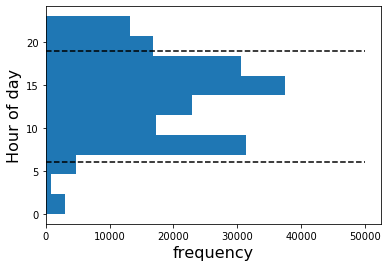

In [10]:
plt.hist(gdf.hour, orientation='horizontal')
plt.xlabel("frequency", size=16)
plt.hlines(6,0,50000, linestyles='--')
plt.hlines(19,0,50000, linestyles='--')
plt.ylabel("Hour of day", size=16)

In [11]:
# 0 == False
# 1 == True
print("start count\n", gdf.startrush.value_counts(), "\n")
print("end count\n", gdf.endrush.value_counts(), "\n")
print("through count\n", gdf.thrurush.value_counts(), "\n")

start count
 0    95576
1    82362
Name: startrush, dtype: int64 

end count
 0    92537
1    85401
Name: endrush, dtype: int64 

through count
 0    101372
1     76566
Name: thrurush, dtype: int64 



In [12]:
rushhour_arr = np.append(gdf.startrush.value_counts().values,gdf.endrush.value_counts().values)
rushhour_arr = np.append(rushhour_arr, gdf.thrurush.value_counts().values)

In [13]:
rushhour_arr

array([ 95576,  82362,  92537,  85401, 101372,  76566])

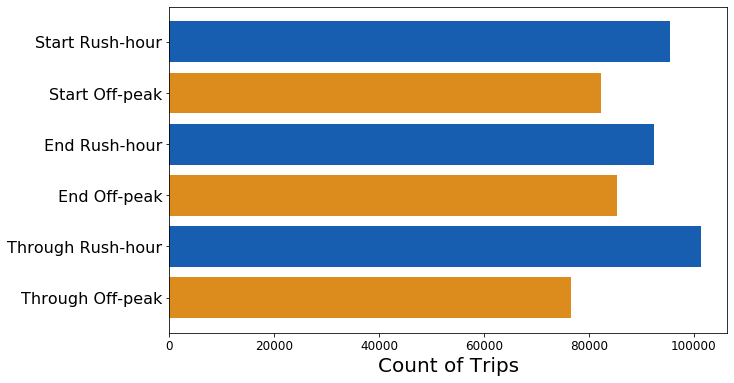

In [90]:
plt.subplots(1, figsize=(10,6))
plt.barh(["Start Rush-hour","Start Off-peak", "End Rush-hour","End Off-peak", "Through Rush-hour","Through Off-peak"], rushhour_arr, color=["#175eb0", "#db8c1d"])
plt.gca().invert_yaxis()
plt.xlabel("Count of Trips", size=20)
plt.xticks(size=12)
plt.yticks(size=16)
# plt.savefig("figures/rushhour_bar_counts.png", bbox_inches='tight')


### Group-by

In [106]:
time_group = '1h'
count_mode = gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq=time_group), 'mode']).count()
count_mode.reset_index(inplace=True)
count_mode.set_index('starttime', inplace=True)

count_purpose = gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq=time_group), 'purpose']).count()
count_purpose.reset_index(inplace=True)
count_purpose.set_index('starttime', inplace=True)

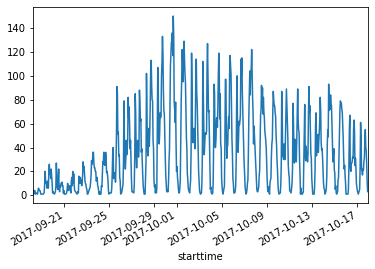

In [107]:
the_mode = 'car'
count_mode.loc[count_mode['mode'] == the_mode]['id_trip'].plot()

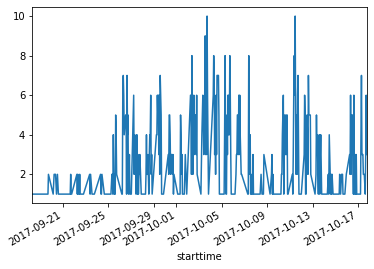

In [108]:
the_purpose = 'health'
count_purpose.loc[count_purpose['purpose'] == the_purpose]['id_trip'].plot()

25

In [120]:
for pr in count_purpose['purpose'].unique():
    
    adf = adfuller([int(i) for i in count_purpose.loc[count_purpose['purpose'] == pr]['id_trip'].values])
    print(sum([int(i) for i in count_purpose.loc[count_purpose['purpose'] == pr]['id_trip'].values]))
    print(pr, 'ADF Statistic: %f' % adf[0], 'p-value: %f' % adf[1])

1592
pick_up_a_person ADF Statistic: -2.868635 p-value: 0.049119
8554
shops ADF Statistic: -1.966911 p-value: 0.301267
19241
work ADF Statistic: -2.259433 p-value: 0.185385
1061
health ADF Statistic: -4.133804 p-value: 0.000851
27128
returning_home ADF Statistic: -2.854256 p-value: 0.050932
9379
leisure ADF Statistic: -1.860116 p-value: 0.351050
2830
education ADF Statistic: -2.868939 p-value: 0.049081
1219
other ADF Statistic: -2.496345 p-value: 0.116366
3189
cafe ADF Statistic: -2.738591 p-value: 0.067595
25
not_available ADF Statistic: -4.795832 p-value: 0.000055


In [116]:
adf = adfuller([int(i) for i in gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq='1h')]).agg({'id_trip':'count'}).values])
print('ADF Statistic: %f' % adf[0], 'p-value: %f' % adf[1])

ADF Statistic: -2.726127 p-value: 0.069625


In [102]:
## look at my home-made function to group the data by units and purpose
help(temporal_functions.group_purpose_24hr)

Help on function group_purpose_24hr in module temporal_functions:

group_purpose_24hr(data, purpose, column='starttime', time_grp=1, units='h')
    Groups the data by purpose for a given time period and then takes the average across a 24-day.
    Note: doesn't divide the data into week/weekends
    
    Paramaters:
    -----------
    data : geopandas.GeoDataFrame
        contains the MTL-Trajet information
    purpose : string
        the purpose of the trip entered by user
    columns : string
        column containing the 
    time : int or string
        time to group each day into
    units : string
        units for the time (i.e. h or min)



In [12]:
gdf.groupby(['mode']).count()['id_trip'][gdf.groupby(['mode']).count()['id_trip'] > 1000]

mode
car                          24744
cycling                      13595
public_transport             12935
walking                      11062
walking, public_transport     6234
Name: id_trip, dtype: int64

In [15]:
data = gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq='1h')]).agg({'id_trip':'count'})

In [16]:
unit_vals = {}
for tm in data.index.hour.unique():
    tm_mean = data.loc[(data.index.hour == tm)]
    tm_mean = tm_mean.mean().values[0]
    unit_vals[tm] = tm_mean

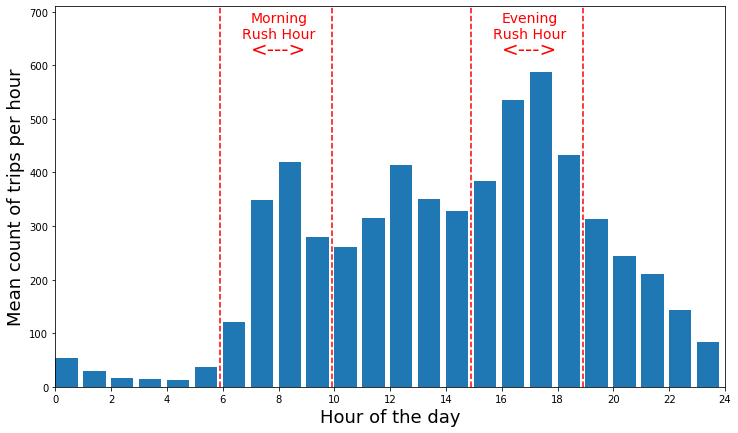

In [28]:
fig, ax = plt.subplots(1, figsize=(12, 7))
plt.bar(x=np.arange(24),height=list(unit_vals.values()), align='edge')
plt.ylabel("Mean count of trips per hour", size=18)
plt.xlabel("Hour of the day", size=18)
plt.xlim(0,24)
plt.locator_params(axis='x', nbins=12)
plt.vlines(x=5.9, ymin=0, ymax=710, linestyles='--', color='red'); plt.vlines(x=9.9, ymin=0, ymax=710, linestyles='--', color='red')
plt.vlines(x=14.9, ymin=0, ymax=710, linestyles='--', color='red'); plt.vlines(x=18.9, ymin=0, ymax=710, linestyles='--', color='red')
plt.text(s="Morning", x=7, y=680, color='red', size=14); plt.text(s="Rush Hour", x=6.7, y=650, color='red', size=14); plt.text(s="<--->", x=7, y=620, color='red', size=20)
plt.text(s="Evening", x=16, y=680, color='red', size=14); plt.text(s="Rush Hour", x=15.7, y=650, color='red', size=14); plt.text(s="<--->", x=16, y=620, color='red', size=20)
plt.ylim(0,710)
# plt.savefig("figures/overall_24hr_bar.png", bbox_inches='tight')

In [33]:
res = seasonal_decompose(gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq='1h')]).agg({'id_trip':'count'}), freq=24)

In [29]:
res1 = stldecompose.decompose(gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq='1h')]).agg({'id_trip':'count'}), period=24)

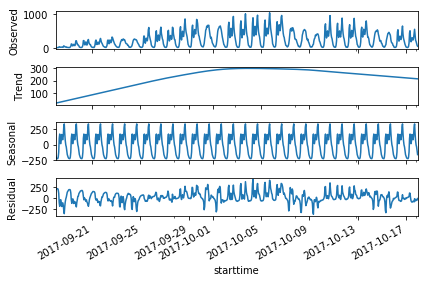

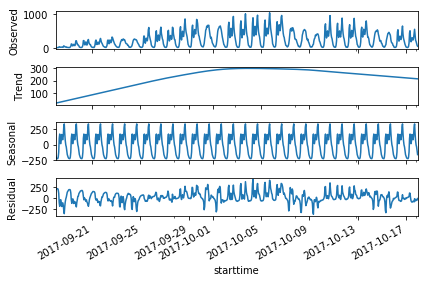

In [31]:
res1.plot()

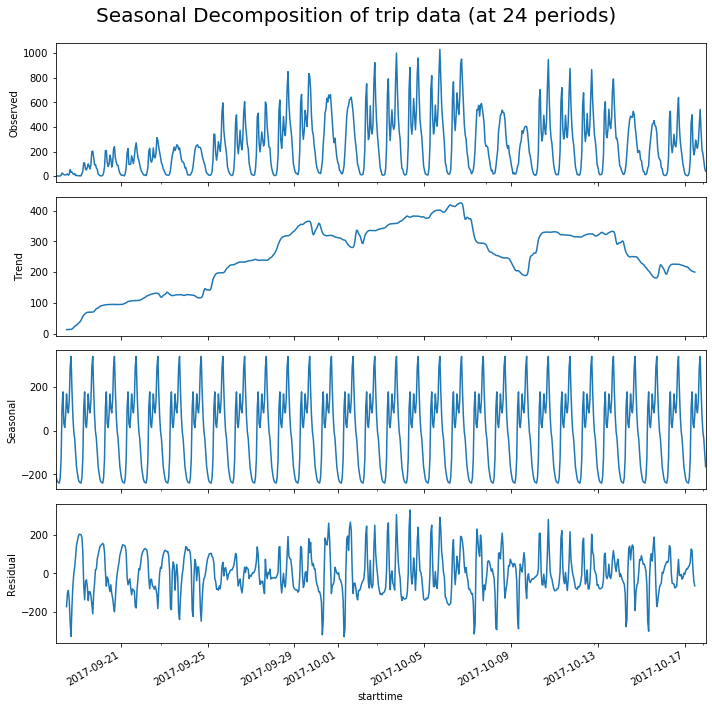

In [35]:
# see https://otexts.com/fpp2/stl.html
plt.rcParams['figure.figsize'] = (10,10)
res.plot()
plt.suptitle("Seasonal Decomposition of trip data (at 24 periods)", size=20)
plt.subplots_adjust(top=.93)
# plt.savefig('figures/seasonal_decomp_hourly.png', bbox_inches='tight')

In [95]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        data series
    maxlag : int
        Maximum lag which is included in test, default 12*(nobs/100)^{1/4}
    regression : {'c','ct','ctt','nc'}
        Constant and trend order to include in regression
    
        * 'c' : constant only (default)
        * 'ct' : constant and trend
        * 'ctt' : constant, and linear and quadratic trend
        * 'nc' : no constant, no trend
    autolag : {'AIC', 'BIC', 't-stat', None}
        * if None, then maxlag lags are used
        * if 'AIC' (default) or 'BIC', then the number of lags is chosen
          to minimize the corresponding information 

In [105]:
# Augmented Dickey-Fuller (ADF) test – tests the extent to which a time series is determined by a trend (unit-root test)
# null == non-stationary
adf = adfuller([int(i) for i in gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq='1h')]).agg({'id_trip':'count'}).values])
print('ADF Statistic: %f' % adf[0], 'p-value: %f' % adf[1])
print('Critical Values:')
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.726127 p-value: 0.069625
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


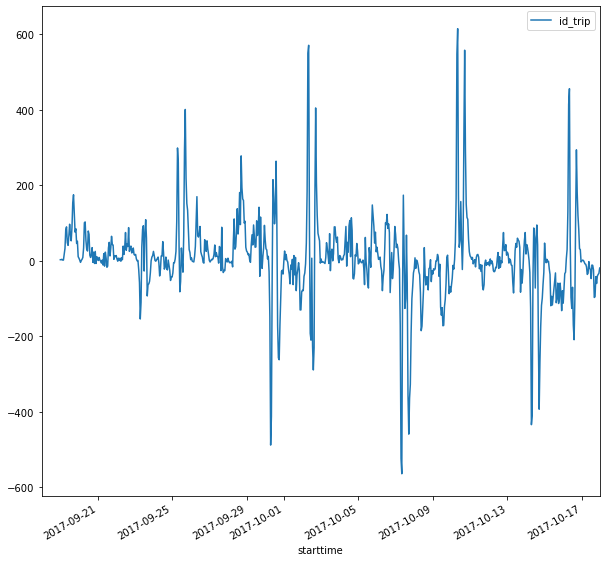

In [89]:

gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq='1h')]).agg({'id_trip':'count'}).diff(periods=24).plot()

Text(0.5, 1.0, 'Count of trips per hour')

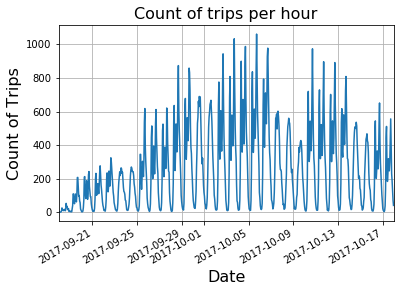

In [10]:
gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq='1h')]).agg({'id_trip':'count'}).plot(grid=True, legend=False)
# plt.gca().get_lefend
plt.ylabel("Count of Trips", size=16)
plt.xlabel("Date", size=16)
plt.title("Count of trips per hour", size=16)
# plt.savefig("figures/count_trips_per_hour.png", bbox_inches='tight')

Text(0.5, 1.0, 'Count of trips by purpose')

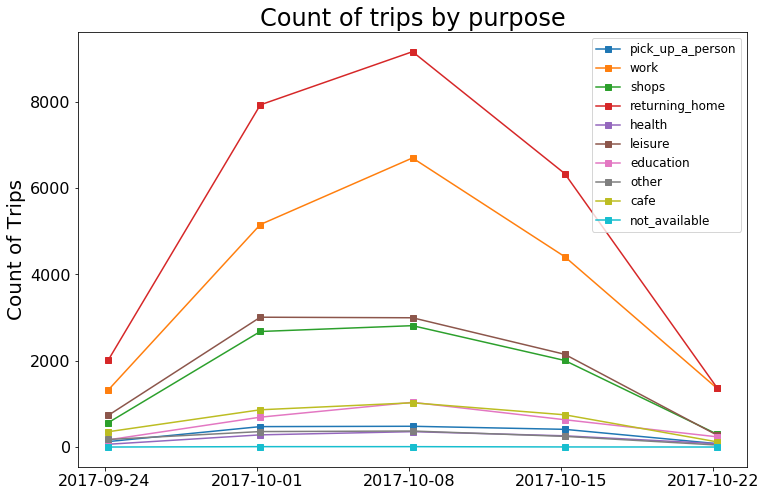

In [107]:
fig, ax = plt.subplots(1, figsize=(12,8))
[plt.plot(a['id_trip'], marker='s') for a in [gdf.loc[gdf.purpose == pur].set_index("starttime").groupby(gpd.pd.Grouper(freq='1w')).count() for pur in gdf.purpose.unique()[1:]]]
plt.xticks(gpd.pd.date_range("2017-09-18","2017-10-22", freq='1w'), rotation=0, size=16)
plt.yticks(size=16)
plt.ylabel("Count of Trips", size=20)
plt.legend([str(p) for p in gdf.purpose.unique()[1:]], fontsize=12)
plt.title("Count of trips by purpose", size=24)
# plt.savefig("figures/count_trips_by_week_purpose.png", bbox_inches='tight')

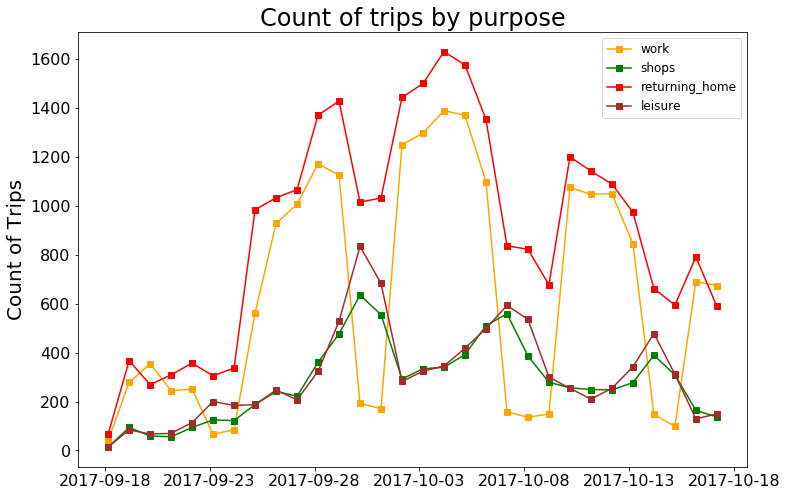

In [118]:
fig, ax = plt.subplots(1, figsize=(12,8))
[plt.plot(a['id_trip'], marker='s', color=c) for a, c in zip([gdf.loc[gdf.purpose == pur].set_index("starttime").groupby(gpd.pd.Grouper(freq='1d')).count() for pur in ["work","shops","returning_home","leisure"]], ['orange','green','red','brown'])]
plt.xticks(gpd.pd.date_range("2017-09-18","2017-10-18", freq='5d'), rotation=0, size=16)
plt.yticks(size=16)
plt.ylabel("Count of Trips", size=20)
plt.legend([str(p) for p in ["work","shops","returning_home","leisure"]], fontsize=12)
plt.title("Count of trips by purpose", size=24)
# plt.savefig("figures/count_trips_by_day_pop.png", bbox_inches='tight')

Text(0.5, 1, 'Correlation matrix (n=30)')

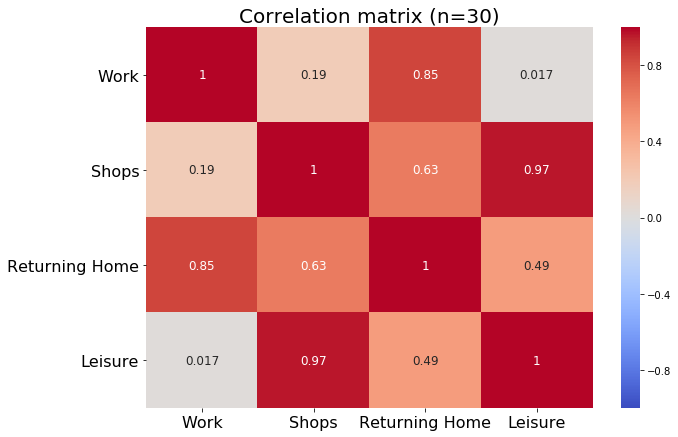

In [141]:
fig, ax = plt.subplots(1, figsize=(10,7))
sns.heatmap(pd.DataFrame([a['id_trip'] for a in [gdf.loc[gdf.purpose == pur].set_index("starttime").groupby(gpd.pd.Grouper(freq='1d')).count() for pur in ["work","shops","returning_home","leisure"]]]).T.corr(), cmap='coolwarm',vmin=-1, vmax=1,annot=True, annot_kws={'fontsize':12})
ax.set_xticklabels(["Work","Shops","Returning Home","Leisure"], size=16)
ax.set_yticklabels(["Work","Shops","Returning Home","hLeisure"], size=16, rotation=0)
ax.set_title("Correlation matrix (n=30)", size=20)

In [480]:
data = gdf.set_index('starttime').groupby([gpd.pd.Grouper(freq='1h')]).agg({'id_trip':'count'})

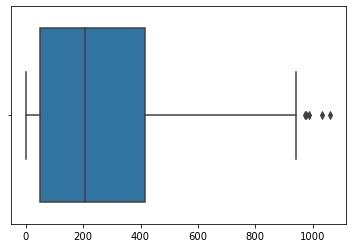

In [479]:
sns.boxplot(data)

In [503]:
data.head()

,id_trip
starttime,
2017-09-18 00:00:00-04:00,1
2017-09-18 01:00:00-04:00,0
2017-09-18 02:00:00-04:00,1
2017-09-18 03:00:00-04:00,0
2017-09-18 04:00:00-04:00,0


In [567]:
pd.date_range('2017-09-18', '2017-10-17', freq='D')

DatetimeIndex(['2017-09-18', '2017-09-19', '2017-09-20', '2017-09-21',
               '2017-09-22', '2017-09-23', '2017-09-24', '2017-09-25',
               '2017-09-26', '2017-09-27', '2017-09-28', '2017-09-29',
               '2017-09-30', '2017-10-01', '2017-10-02', '2017-10-03',
               '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07',
               '2017-10-08', '2017-10-09', '2017-10-10', '2017-10-11',
               '2017-10-12', '2017-10-13', '2017-10-14', '2017-10-15',
               '2017-10-16', '2017-10-17'],
              dtype='datetime64[ns]', freq='D')

In [37]:
data_per_hour_t = pd.concat([data[data.index.hour == x].reset_index()['id_trip'] for x in range(0,24)], axis=1).T
data_per_hour_t.index = np.arange(0,24)
data_per_hour_t.columns = [str(dt.date()) for dt in pd.date_range('2017-09-18', '2017-10-17', freq='D')]
data_per_hour_t.head()

,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,...,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17
0,1,3,9,12,26,43,68,21,26,27,...,127,94,33,47,43,68,84,126,19,20
1,0,2,5,5,11,25,40,8,14,11,...,77,54,14,21,11,26,72,76,6,9
2,1,3,1,8,7,12,10,8,8,9,...,42,18,8,10,13,11,45,38,5,7
3,0,2,2,5,9,9,11,6,4,5,...,48,27,6,13,7,12,30,34,6,2
4,0,2,6,1,4,7,7,13,10,12,...,17,16,19,11,12,14,13,12,14,8


Text(105.0, 0.5, 'Date')

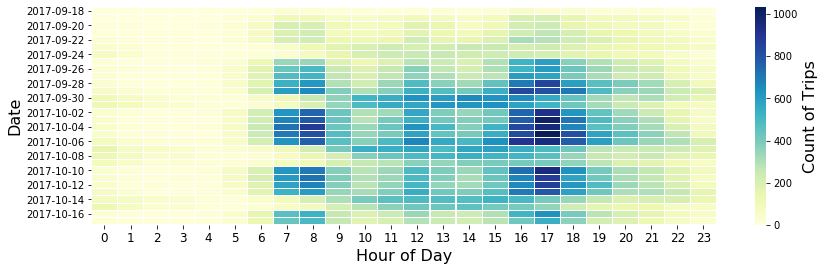

In [38]:
fig, ax = plt.subplots(1, figsize=(14,4))
sns.heatmap(data_per_hour_t.T,ax=ax, cmap='YlGnBu', linewidths=.1, annot=False, fmt='.0f', cbar_kws={'label': 'Count of Trips', "orientation": "vertical"});
ax.set_xticklabels(labels=np.arange(0,24),rotation=0);
ax.figure.axes[-1].yaxis.label.set_size(16)
plt.xticks(size=12)
plt.xlabel("Hour of Day", size=16)
plt.ylabel("Date", size=16)
# plt.title("", size=18)
# plt.savefig("figures/grouped_hour_heatmap.png", bbox_inches='tight')

In [616]:
data_per_hour_t

,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,...,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17
0,1,4,11,15,29,44,69,26,29,30,...,134,99,35,48,45,68,86,133,21,21
1,0,3,5,6,11,28,42,10,18,15,...,81,60,14,24,11,29,72,81,8,10
2,1,5,1,10,9,14,15,10,9,10,...,44,20,8,12,17,11,46,41,7,8
3,0,2,3,5,12,12,11,6,4,8,...,49,28,6,15,7,12,32,36,6,3
4,0,2,6,5,6,7,10,15,12,15,...,17,17,20,12,12,14,15,12,18,10
5,1,19,28,22,29,6,12,37,49,56,...,19,19,68,66,59,48,17,16,46,37
6,7,40,74,76,75,17,27,131,169,186,...,25,42,207,210,184,172,46,25,156,140
7,25,108,209,198,206,52,46,345,445,487,...,78,88,636,620,591,534,100,64,478,442
8,19,109,212,231,234,124,84,344,514,525,...,146,105,720,729,702,617,207,88,544,511
9,12,60,114,100,139,176,153,192,259,281,...,225,216,390,406,389,363,317,223,275,273


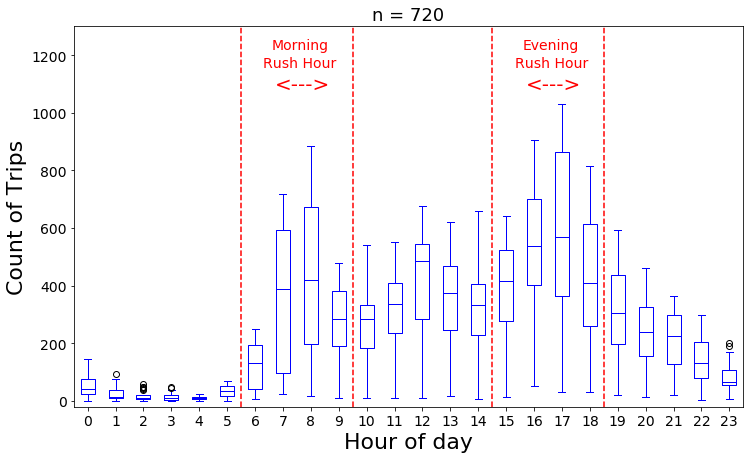

In [67]:
fig, ax = plt.subplots(1, figsize=(12,7))
pd.concat([data[data.index.hour == x].reset_index()['id_trip'] for x in range(0,24)], axis=1).plot(kind='box',color='blue', ax=ax)
ax.set_xticklabels(np.arange(24));
ax.set_xlabel("Hour of day", size=22)
ax.set_ylabel("Count of Trips", size=22)
plt.ylim(-20,1300)
plt.vlines(x=6.5, ymin=-20, ymax=1300, linestyles='--', color='red'); plt.vlines(x=10.5, ymin=-20, ymax=1300, linestyles='--', color='red')
plt.vlines(x=15.5, ymin=-20, ymax=1300, linestyles='--', color='red'); plt.vlines(x=19.5, ymin=-20, ymax=1300, linestyles='--', color='red')
plt.text(s="Morning", x=7.6, y=1220, color='red', size=14); plt.text(s="Rush Hour", x=7.3, y=1160, color='red', size=14); plt.text(s="<--->", x=7.7, y=1080, color='red', size=20)
plt.text(s="Evening", x=16.6, y=1220, color='red', size=14); plt.text(s="Rush Hour", x=16.3, y=1160, color='red', size=14); plt.text(s="<--->", x=16.7, y=1080, color='red', size=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("n = 720", size=18)
# plt.savefig("figures/av_trips_boxplot_perhour.png", bbox_inches='tight')

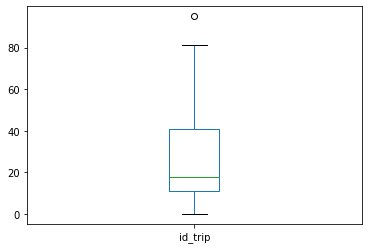

In [478]:
data[data.index.hour == 1].plot(kind='box')

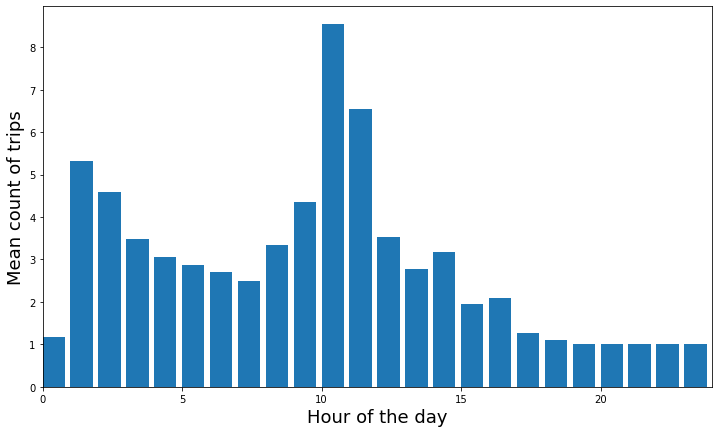

In [74]:
# %%snakeviz
# crashes a lot
fig, ax = plt.subplots(1, figsize=(12, 7))
cafe_tprof = temporal_functions.group_var_24hr(gdf, 'pick_up_a_person', time_grp=1, units='h')
plt.bar(x=np.arange(24),height=list(cafe_tprof.values()), align='edge')
# plt.gca().invert_yaxis()
plt.ylabel("Mean count of trips", size=18)
plt.xlabel("Hour of the day", size=18)
plt.xlim(0,24)

# plt.savefig("figures/pickup_24hr_bar.png", bbox_inches='tight')

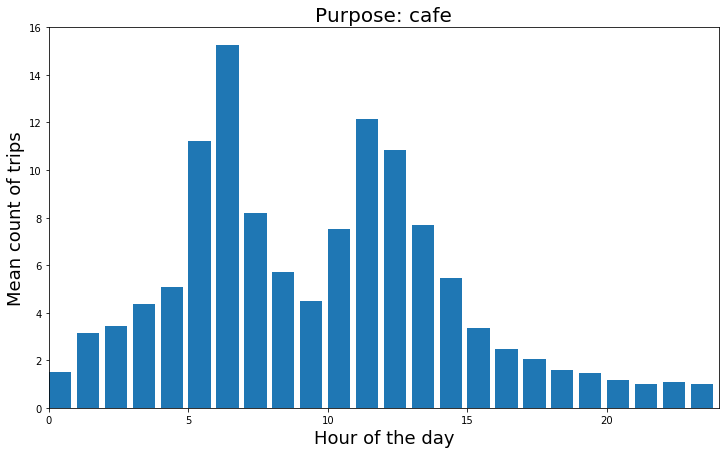

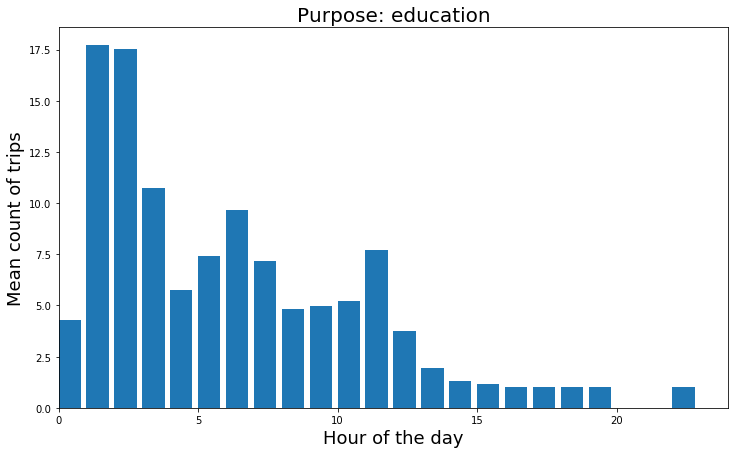

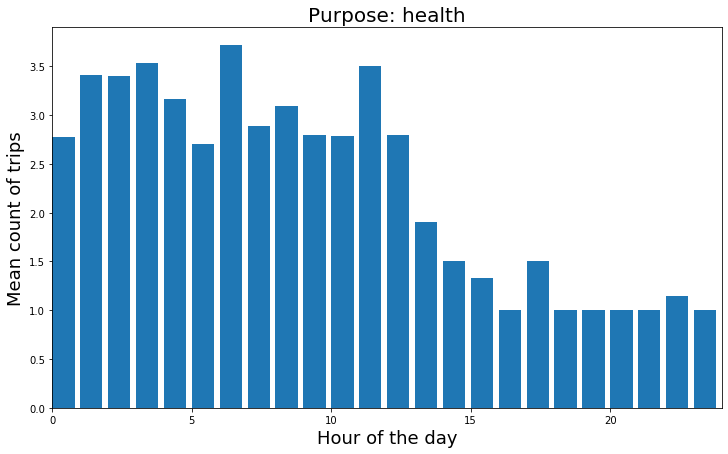

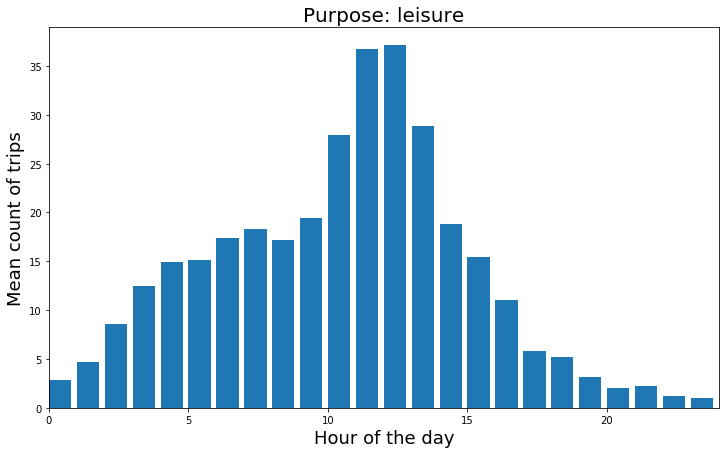

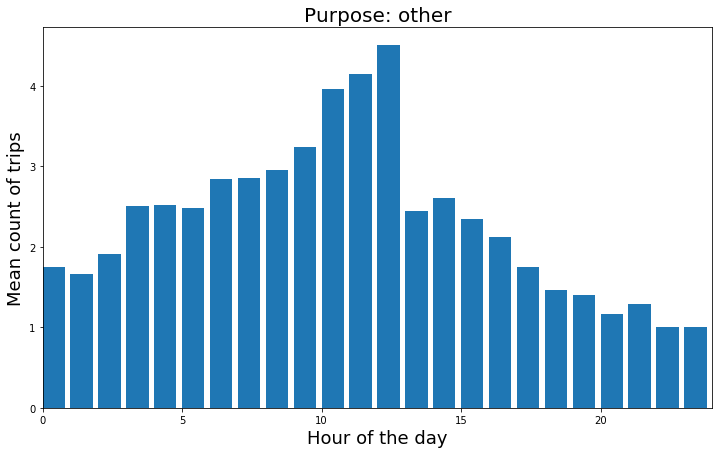

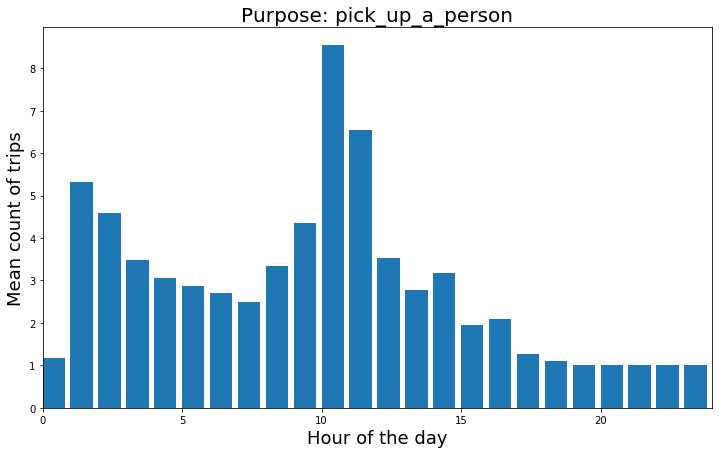

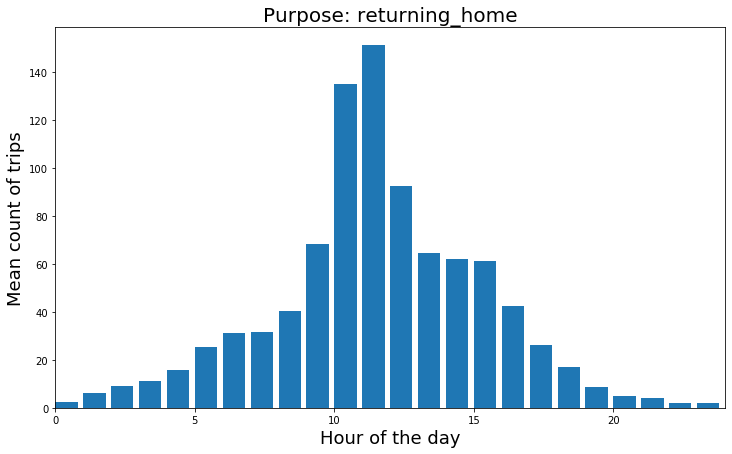

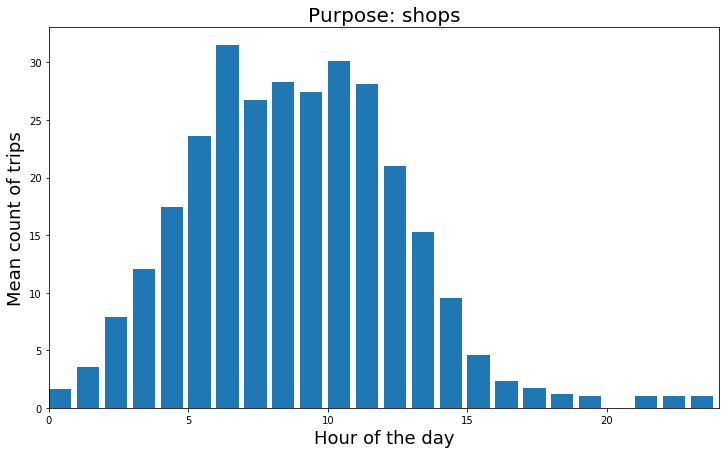

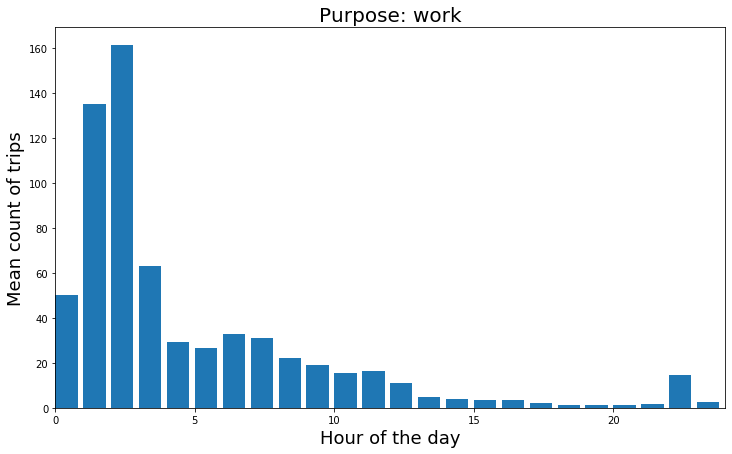

In [99]:
for purpose in above1000_purpose:
    fig, ax = plt.subplots(1, figsize=(12, 7))
    cafe_tprof = temporal_functions.group_var_24hr(gdf, purpose, time_grp=1, units='h', purpose=True)
    plt.bar(x=np.arange(24),height=list(cafe_tprof.values()), align='edge')
    # plt.gca().invert_yaxis()
    plt.ylabel("Mean count of trips", size=18)
    plt.xlabel("Hour of the day", size=18)
    plt.title("Purpose: "+ purpose, size=20)
    plt.xlim(0,24)
#     plt.savefig("figures/{0}_24hr_bar.png".format(purpose), bbox_inches='tight')
    plt.show()
    plt.close()


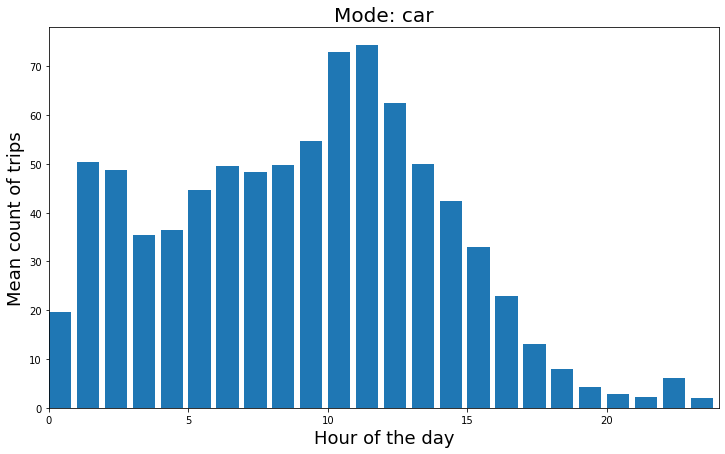

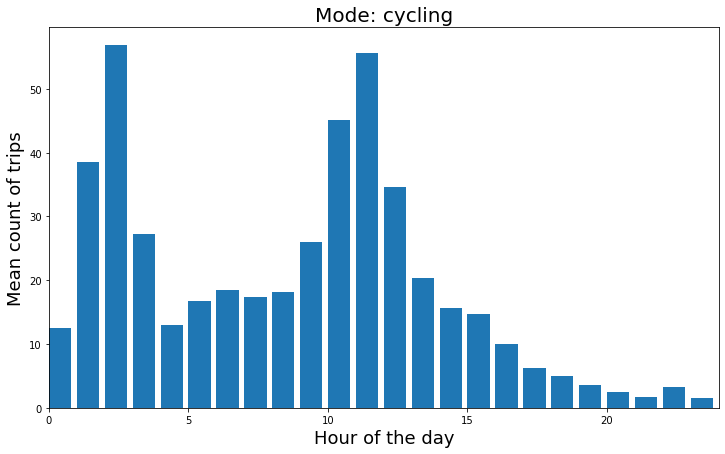

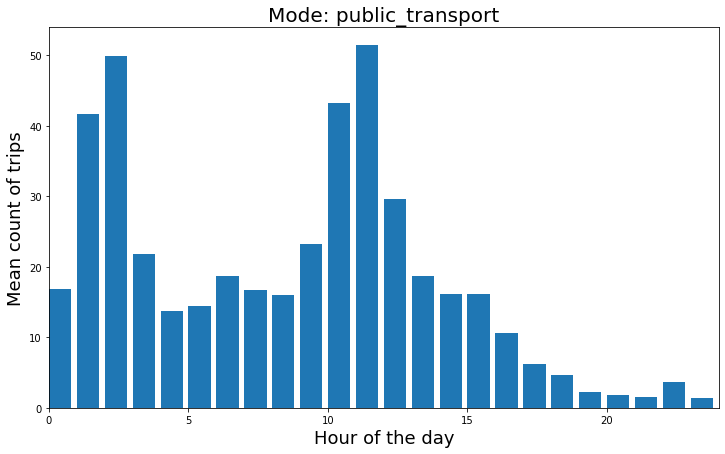

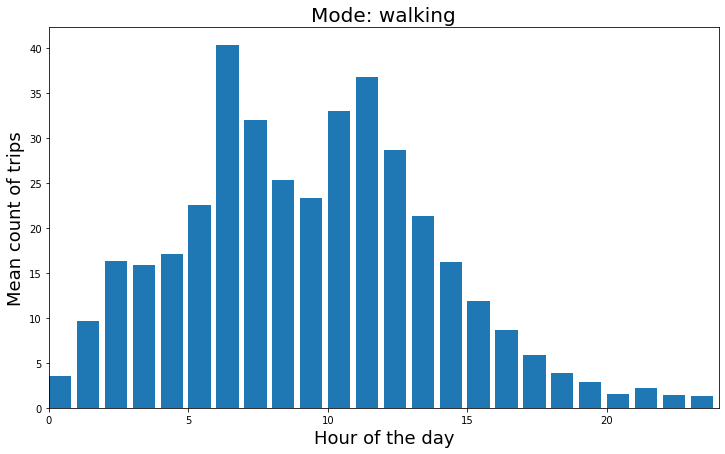

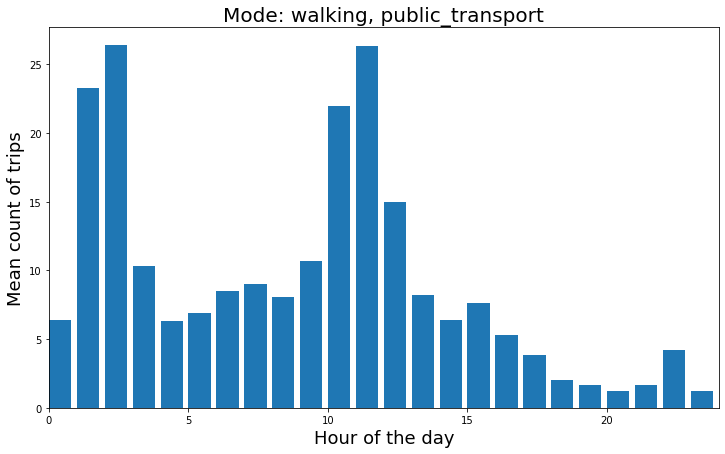

In [100]:
for mode in above1000_mode:
    fig, ax = plt.subplots(1, figsize=(12, 7))
    cafe_tprof = temporal_functions.group_var_24hr(gdf, mode, time_grp=1, units='h', purpose=False)
    plt.bar(x=np.arange(24),height=list(cafe_tprof.values()), align='edge')
    # plt.gca().invert_yaxis()
    plt.ylabel("Mean count of trips", size=18)
    plt.xlabel("Hour of the day", size=18)
    plt.title("Mode: "+ mode, size=20)
    plt.xlim(0,24)
#     plt.savefig("figures/{0}_24hr_bar.png".format(mode), bbox_inches='tight')
    plt.show()
    plt.close()

## temporal calendar (week and hour)

In [7]:
def group_var_24hr(data, var, column='starttime', time_grp=1 ,units='h', purpose=True):
    """
    Groups the data by purpose or mode for a given time period and then takes the average across a 24-day.
    Note: doesn't divide the data into week/weekends
    
    Paramaters:
    -----------
    data : geopandas.GeoDataFrame
        contains the MTL-Trajet information
    var : string
        the purpose or mode of the trip entered by user
    columns : string
        column containing the 
    time : int or string
        time to group each day into
    units : string
        units for the time (i.e. h or min)
        
    """
    unit_vals = {} # dictionary for holding the mean value at each time unit
    
    try:
        column = str(column)
        time_grp = int(time_grp)
        assert column in data.columns, "\'%s\' not found as a column in data" % column
        if purpose:
            assert 'purpose' in data.columns, "\'purpose\' not found as a column in data"
        else:
            assert 'mode' in data.columns, "\'mode\' not found as a column in data"
    except:
        raise TypeError ("invalid input")
    
    freq_units = str(time_grp)+units
    
    if purpose:
        data = data.set_index(column).groupby([gpd.pd.Grouper(freq=freq_units), 'purpose']).agg({'id_trip':'count'})
    else:
        data = data.set_index(column).groupby([gpd.pd.Grouper(freq=freq_units), 'mode']).agg({'id_trip':'count'})
    data.reset_index(inplace=True)
    data.set_index(column, inplace=True)
    
    if units == 'h':
        num = int(np.floor(24 / int(time_grp)))
#         periods = np.arange(int(24/num)-1,24, time_grp)
        ind_time_units = data.index.hour
    elif units == 'min':
        num = int(np.floor((1440) / int(time_grp)))
#         periods = np.arange(int(1440/num)-1,1440, time_grp)
        ind_time_units = data.index.minute
    else:
        return print("please enter appropriate units: \'h\' or \'min\'")

    for tm in data.index.hour.unique():
        if purpose:
            tm_mean = data.loc[(ind_time_units == tm) & (data['purpose'] == var)]
        else:
            tm_mean = data.loc[(ind_time_units == tm) & (data['mode'] == var)]
        tm_mean = tm_mean.mean().values[0]
        unit_vals[tm] = tm_mean
    return unit_vals

0          568
1         2463
2         2824
3          862
4          544
          ... 
177933      67
177934     520
177935     364
177936     581
177937      95
Name: seconds, Length: 177938, dtype: int64

In [104]:
np.percentile(gdf.distance_m, 95)/1000

25.24773662979777

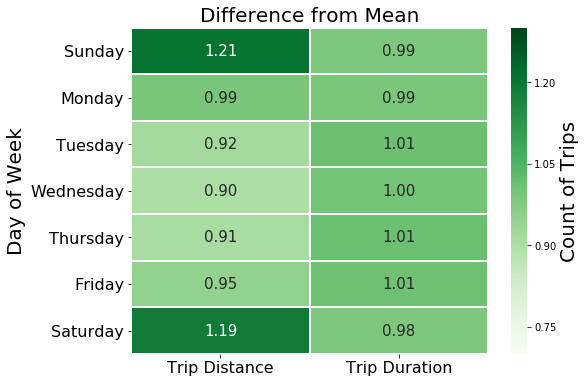

In [93]:
fig, ax = plt.subplots(1, figsize=(8,6))
mean_day_dist_time = gdf.groupby([gdf.starttime.dt.weekday_name]).agg({'distance_m':'mean', 'seconds':'mean'}) /[gdf.distance_m.mean(), gdf.seconds.mean()]
mean_day_dist_time = mean_day_dist_time.reindex(ordered_days)
sns.heatmap(mean_day_dist_time,cmap='Greens', vmin=0.7, vmax=1.3, center=1, linewidths=1, annot=True, annot_kws={"size": 15}, fmt='.2f', cbar_kws={'label': 'Count of Trips'})
ax.set_xticklabels(labels=['Trip Distance', 'Trip Duration'], size=16)
ax.set_yticklabels(labels=ordered_days, size=16)
ax.set_title("Difference from Mean", size=20)
ax.set_ylabel("Day of Week", size=20)
ax.figure.axes[-1].yaxis.label.set_size(20)
# plt.savefig("figures/mean_week_time_dist.png", bbox_inches='tight')
plt.show()

In [75]:
def group_var_calendar(data, var=None, column='starttime', purpose=True):
    """
    Groups the data by purpose or mode across the week for each hour
    
    Paramaters:
    -----------
    data : geopandas.GeoDataFrame
        contains the MTL-Trajet information
    var : string
        i.e. 'purpose' or 'mode' of the trip
    columns : string
        column containing the datetime variable to group by
    time : int or string
        time to group each day into
    units : string
        units for the time (i.e. h or min)
        
    """
    ordered_days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
    ## groupby all modes 
    if purpose:
        data = data.set_index(column).groupby([gpd.pd.Grouper(freq='1h'), 'purpose']).agg({'id_trip':'count'})
    else:
        data = data.set_index(column).groupby([gpd.pd.Grouper(freq='1h'), 'mode']).agg({'id_trip':'count'})
    data.reset_index(inplace=True)
    week_hours = {}
    
    for hr in range(0, 24):
        # check if var has been stated or just do total
        if var:
           
            if purpose:
                assert var in data['purpose'].unique(), "var: \'%s\' is not in the purpose column of the dataframe" % (var)
                hr_data = data.loc[(data.starttime.apply(lambda tm: tm.hour == hr)) & (data['purpose'] == var)]
            else:
                assert var in data['mode'].unique(), "var: \'%s\' is not in the mode column of the dataframe" % (var)
                hr_data = data.loc[(data.starttime.apply(lambda tm: tm.hour == hr)) & (data['mode'] == var)] 
        else:
            print("here")
            hr_data = data.loc[data.starttime.apply(lambda tm: tm.hour == hr)]
            
        hr_data = hr_data.groupby(hr_data.starttime.dt.weekday_name).mean().reindex(ordered_days) # re-order index by day
        week_hours[hr] = hr_data.values
    return week_hours

Text(69.0, 0.5, 'Day of Week')

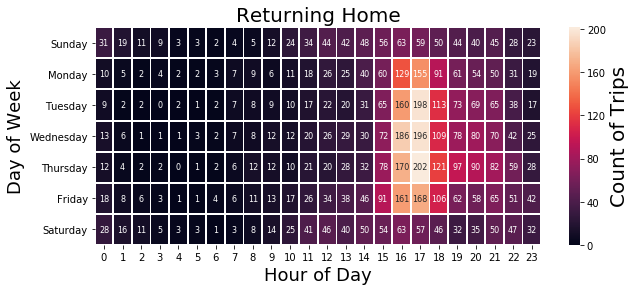

In [76]:
var_calendar = np.concatenate(list(temporal_functions.group_var_calendar(gdf, var='returning_home').values()),axis=1)
var_calendar = np.nan_to_num(var_calendar) # equivalent to fillna
fig, ax = plt.subplots(1, figsize=(10,4))
sns.heatmap(var_calendar, vmin=0, linewidths=1, annot=True, annot_kws={"size": 8}, fmt='.0f', cbar_kws={'label': 'Count of Trips'})
ax.set_yticklabels(ordered_days, rotation=0);
ax.figure.axes[-1].yaxis.label.set_size(20)
plt.title("Returning Home", size=20)
plt.xlabel("Hour of Day", size=18)
plt.ylabel("Day of Week", size=18)

#### Do all purposes and modes

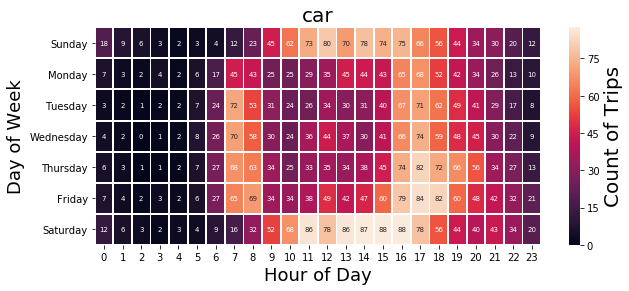

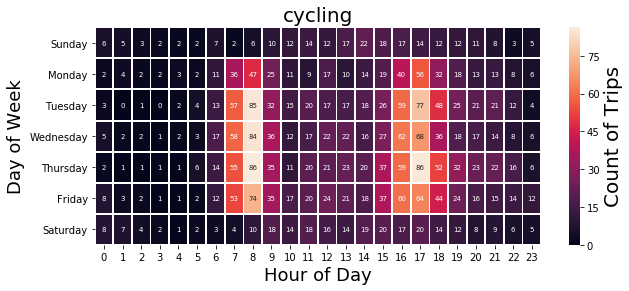

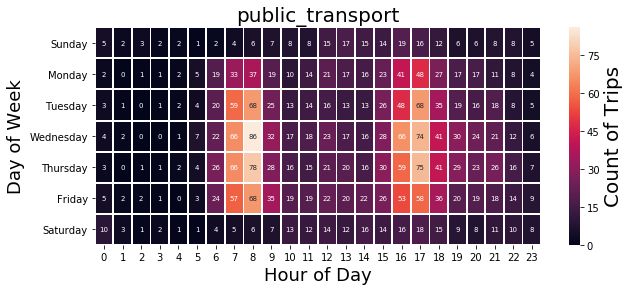

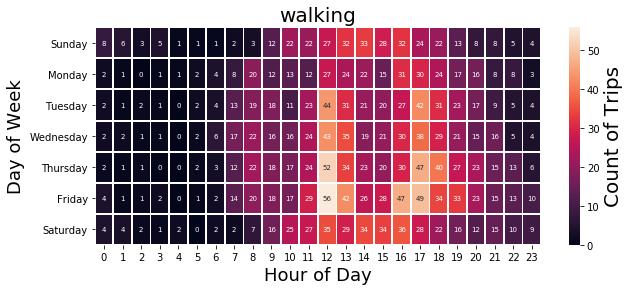

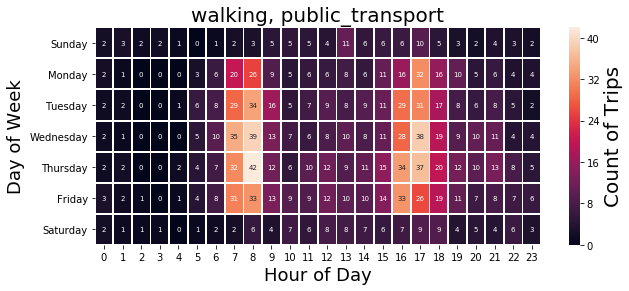

In [66]:
for var in above1000_mode:
    var_calendar = np.concatenate(list(temporal_functions.group_var_calendar(gdf, var=var, purpose=False).values()),axis=1)
    var_calendar = np.nan_to_num(var_calendar) # equivalent to fillna
    fig, ax = plt.subplots(1, figsize=(10,4))
    sns.heatmap(var_calendar, vmin=0, linewidths=1, annot=True, annot_kws={"size": 7}, fmt='.0f', cbar_kws={'label': 'Count of Trips'})
    ax.set_yticklabels(ordered_days, rotation=0);
    ax.figure.axes[-1].yaxis.label.set_size(20)
    plt.title(var, size=20)
    plt.xlabel("Hour of Day", size=18)
    plt.ylabel("Day of Week", size=18)
#     plt.savefig("figures/{0}_calendar.png".format(var), bbox_inches='tight')
    plt.show()
    plt.close()

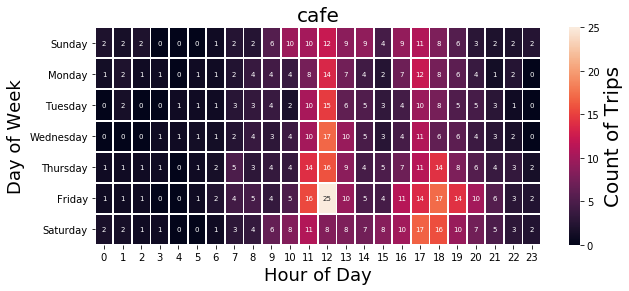

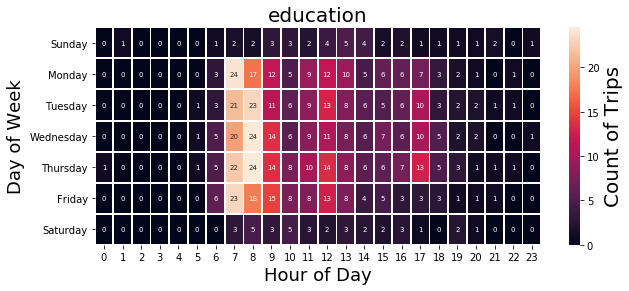

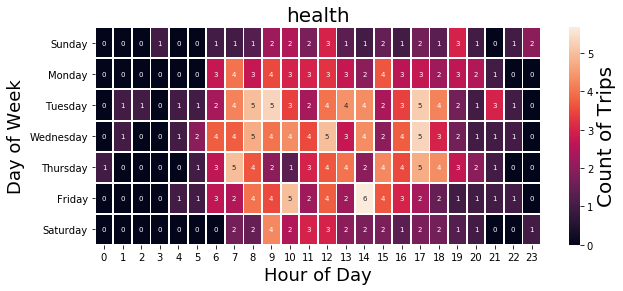

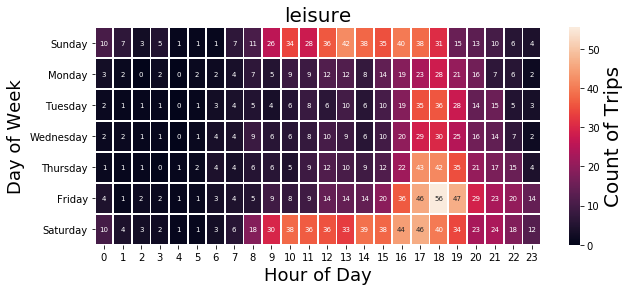

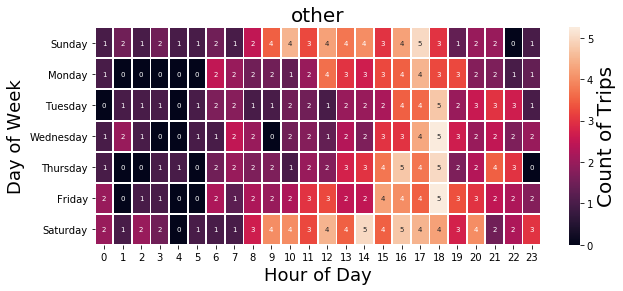

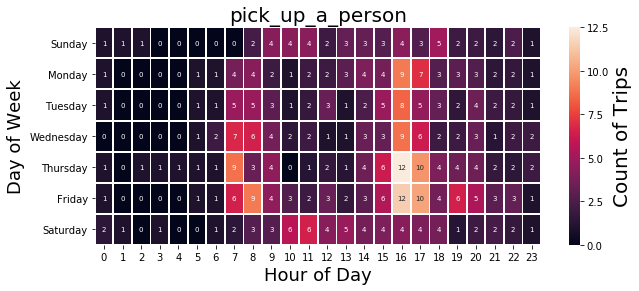

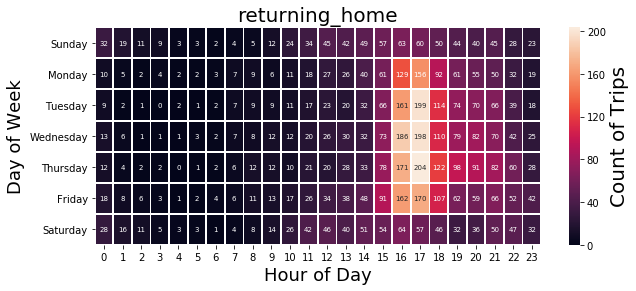

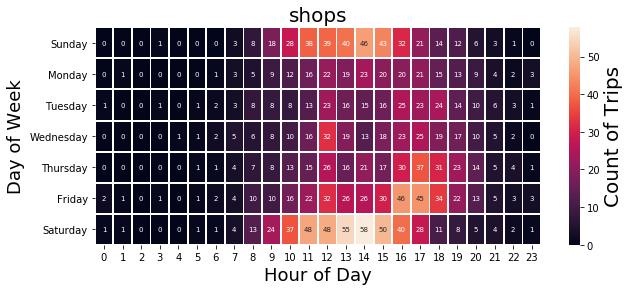

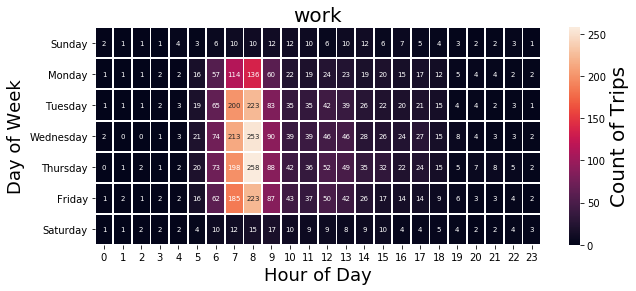

In [65]:
for var in above1000_purpose:
    var_calendar = np.concatenate(list(temporal_functions.group_var_calendar(gdf, var=var, purpose=True).values()),axis=1)
    var_calendar = np.nan_to_num(var_calendar) # equivalent to fillna
    fig, ax = plt.subplots(1, figsize=(10,4))
    sns.heatmap(var_calendar, vmin=0, linewidths=1, annot=True, annot_kws={"size": 7}, fmt='.0f', cbar_kws={'label': 'Count of Trips'})
    ax.set_yticklabels(ordered_days, rotation=0);
    ax.figure.axes[-1].yaxis.label.set_size(20)
    plt.title(var, size=20)
    plt.xlabel("Hour of Day", size=18)
    plt.ylabel("Day of Week", size=18)
#     plt.savefig("figures/{0}_calendar.png".format(var), bbox_inches='tight')
    plt.show()
    plt.close()

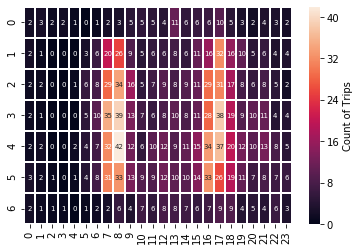

In [112]:
ax = sns.heatmap(var_calendar, vmin=0, linewidths=1, annot=True, annot_kws={"size": 7}, fmt='.0f', cbar_kws={'label': 'Count of Trips'})

## Differencing:

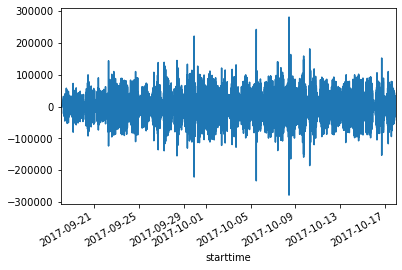

In [125]:
gdf.set_index('starttime')['distance_m'].diff(1).plot()

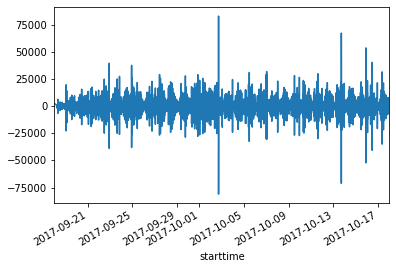

In [126]:
gdf.set_index('starttime')['seconds'].diff(1).plot()

## Autocorrelation function plots
What though?

## Temporal Clustering using LDA
Temporal Words i.e. 'Sunday_9.00, car'.  
Create temporal topics, and then look at their make-up, need a Perplexity score first

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


In [8]:
gdf.head()

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,endrush,thrurush,precip,temperatur,start_wgs,end_wgs,start_can,end_can,geometry,hour
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,0.019003,WNW,...,0,0,0.000004,21.655905,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...,0
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,0.313505,W,...,0,0,0.000000,20.182104,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...,2
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,0.272104,SE,...,1,0,0.000000,18.353766,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...,5
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,0.304086,E,...,1,1,0.000000,18.353766,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...,6
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,0.255485,E,...,1,1,0.000000,18.353766,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...,6


In [9]:
def create_LDA_words(row):
    if row['purpose']:
        return row['starttime'].day_name() + "_" + str(row['hour']) + ", " + row['purpose']

In [10]:
%%time 
# about 1 minute
gdf['lda_word'] = gdf.apply(lambda row: create_LDA_words(row), axis=1)

CPU times: user 32.8 s, sys: 230 ms, total: 33 s
Wall time: 33 s


In [12]:
tokenizer = RegexpTokenizer(r'\w+')
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [13]:
doc_set = list(gdf['lda_word'].dropna())

In [14]:
len(doc_set)

74218

In [15]:
# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [16]:
print(dictionary.token2id)

{'monday_6': 0, 'pick_up_a_person': 1, 'monday_7': 2, 'work': 3, 'shop': 4, 'monday_8': 5, 'returning_hom': 6, 'health': 7, 'monday_9': 8, 'leisur': 9, 'monday_10': 10, 'monday_11': 11, 'monday_12': 12, 'monday_13': 13, 'monday_14': 14, 'monday_15': 15, 'monday_16': 16, 'monday_17': 17, 'educ': 18, 'monday_18': 19, 'monday_19': 20, 'monday_20': 21, 'monday_21': 22, 'monday_22': 23, 'monday_23': 24, 'tuesday_0': 25, 'tuesday_1': 26, 'tuesday_2': 27, 'tuesday_3': 28, 'tuesday_5': 29, 'tuesday_6': 30, 'tuesday_7': 31, 'other': 32, 'tuesday_8': 33, 'tuesday_9': 34, 'cafe': 35, 'tuesday_10': 36, 'tuesday_11': 37, 'tuesday_12': 38, 'tuesday_13': 39, 'tuesday_14': 40, 'tuesday_15': 41, 'tuesday_16': 42, 'tuesday_17': 43, 'tuesday_18': 44, 'tuesday_19': 45, 'tuesday_20': 46, 'tuesday_21': 47, 'tuesday_22': 48, 'tuesday_23': 49, 'wednesday_0': 50, 'wednesday_1': 51, 'wednesday_3': 52, 'wednesday_4': 53, 'wednesday_5': 54, 'wednesday_6': 55, 'wednesday_7': 56, 'wednesday_8': 57, 'wednesday_9': 5

In [637]:
%%time
# generate LDA model
# 30 seconds for 2 passes and 2 topics
# 1 min for 2 passes and 10 topics
# 1 min 30 seconds for 10 passes and 20 topics
## 5 is the best ##
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=10) 

CPU times: user 1min 54s, sys: 1.03 s, total: 1min 55s
Wall time: 2min 1s


In [638]:
topics = ldamodel.print_topics(num_topics=5, num_words=177)

In [639]:
topics

[(0,
  '0.177*"tuesday_20" + 0.153*"cafe" + 0.125*"tuesday_21" + 0.122*"educ" + 0.044*"monday_18" + 0.036*"wednesday_17" + 0.028*"tuesday_12" + 0.027*"friday_12" + 0.027*"monday_19" + 0.026*"tuesday_23" + 0.024*"monday_20" + 0.024*"wednesday_18" + 0.022*"monday_12" + 0.022*"monday_14" + 0.021*"friday_13" + 0.019*"friday_11" + 0.014*"tuesday_11" + 0.014*"wednesday_12" + 0.014*"monday_6" + 0.014*"thursday_11" + 0.007*"monday_23" + 0.006*"wednesday_22" + 0.005*"wednesday_10" + 0.003*"sunday_12" + 0.003*"saturday_17" + 0.003*"tuesday_0" + 0.002*"sunday_13" + 0.002*"sunday_17" + 0.002*"sunday_11" + 0.002*"thursday_13" + 0.002*"sunday_18" + 0.001*"sunday_19" + 0.001*"thursday_10" + 0.001*"saturday_7" + 0.001*"wednesday_1" + 0.000*"thursday_3" + 0.000*"sunday_16" + 0.000*"monday_7" + 0.000*"monday_2" + 0.000*"monday_1" + 0.000*"monday_8" + 0.000*"monday_17" + 0.000*"sunday_0" + 0.000*"tuesday_13" + 0.000*"returning_hom" + 0.000*"monday_11" + 0.000*"saturday_19" + 0.000*"sunday_14" + 0.000*"tu

In [650]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:320: DeprecationWarning: Numpy has detected that you (may be) writing to an array with
overlapping memory from np.broadcast_arrays. If this is intentional
set the WRITEABLE flag True or make a copy immediately before writing.
  i, j, x)
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:320: 


Coherence Score:  0.7436891279592204


In [651]:
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -4.047867489115989


## grid-search

In [369]:
%%time
# 1 hour 10 mins
coherences = []
perplexities = []
for tp_num in range(20, 30):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=tp_num, id2word = dictionary, passes=20) 
    coherence_model_ldamallet = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    log_ldamallet = ldamodel.log_perplexity(corpus)
    coherences.append(coherence_ldamallet)
    perplexities.append(log_ldamallet)
    print('\nCoherence Score: ', coherence_ldamallet)
    print('\nPerplexity: ', log_ldamallet)  # a measure of how good the model is. lower the better.

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):



Coherence Score:  0.571940663259423

Perplexity:  -3.9888694338805077

Coherence Score:  0.6448799442330237

Perplexity:  -3.956618011775978

Coherence Score:  0.6790620513040256

Perplexity:  -4.0604017318273256

Coherence Score:  0.7219313044953481

Perplexity:  -4.014715955170135

Coherence Score:  0.7427519876939975

Perplexity:  -4.119758555189724

Coherence Score:  0.7471433437782234

Perplexity:  -4.115594718854141

Coherence Score:  0.7332471340323049

Perplexity:  -4.1217396594546845

Coherence Score:  0.7339904358627387

Perplexity:  -4.184985092508529

Coherence Score:  0.7110692145567782

Perplexity:  -4.1809048229708505

Coherence Score:  0.7036149386972148

Perplexity:  -4.209085957605238

Coherence Score:  0.7066536451005911

Perplexity:  -4.195043317474904

Coherence Score:  0.6963776355053891

Perplexity:  -4.281937104202447

Coherence Score:  0.6998592307298339

Perplexity:  -4.282551520725353

Coherence Score:  0.6810716543801699

Perplexity:  -4.483791960090519

Co

In [443]:
cohper = pd.DataFrame([coherences, perplexities]).T
cohper.columns = ['coherence','perplexity_score']
cohper.head()

,coherence,perplexity_score
0,0.571941,-3.988869
1,0.644880,-3.956618
2,0.679062,-4.060402
3,0.721931,-4.014716
4,0.742752,-4.119759


In [617]:
# cohper.to_csv('analysis_results/lda_performance_scores', index=False)
cohper = pd.read_csv('analysis_results/lda_performance_scores')

In [619]:
cohper

,coherence,perplexity_score
0,0.571941,-3.988869
1,0.644880,-3.956618
2,0.679062,-4.060402
3,0.721931,-4.014716
4,0.742752,-4.119759
5,0.747143,-4.115595
6,0.733247,-4.121740
7,0.733990,-4.184985
8,0.711069,-4.180905
9,0.703615,-4.209086


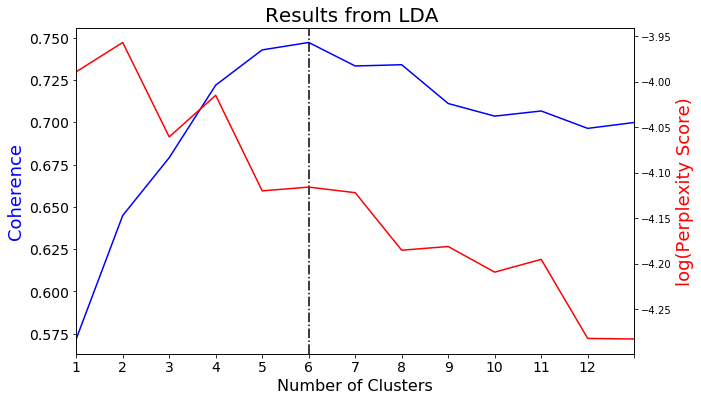

In [718]:
fig, ax = plt.subplots(1, figsize=(10,6))
ax2 = ax.twinx()
ax.plot(cohper.coherence[:13], color='b')
ax2.plot(cohper.perplexity_score[:13], color='r')
ax.set_ylabel('Coherence', color='b', size=18)
ax2.set_ylabel('log(Perplexity Score)', color='r', size=18)
ax.set_title("Results from LDA ", size=20)
plt.xlim(0,12)
plt.xticks(np.arange(0,13), labels=np.arange(1,13))
# ax2.set_ylim(-5,-3.5)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
# for tick in ax2.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)         
ax.axvline(x=5, ymin=0,ymax=10, linestyle='-.', color='k')
ax.set_xlabel("Number of Clusters", size=16)
# plt.savefig("figures/coherence_perplexity_graph_12.png", bbox_inches='tight')

#### Now for the fancy stuff

In [70]:
import re
regex = re.compile('[^a-zA-Z_0-9]') # only accept a-z, A-Z, _ or 0-9
day_nms = ['mon','tues','wedn','thurs','frid','satur','sund']

def get_individual_topics(topic):
    individual_topics = topic[1].split("+")
    return individual_topics

def strip_unneeded_chars(row):
    val, topic = row.split('*')
    val = val.replace(" ", "")
    topic = regex.sub('', topic)
    return float(val), topic

def print_cluster_content(topic):
    ind_tp = get_individual_topics(topic)
    for it in ind_tp:
        val, tp = strip_unneeded_chars(it)
        if val > 0:
            day = False
            for dy in day_nms:
                if tp.startswith(dy):
                    day = True
            if not day:
                print(tp, val)

In [22]:
strip_unneeded_chars(get_individual_topics(topics[1])[1])

(0.159, 'work')

In [23]:
empty_week_profile = np.zeros((7,24)) # empty matrix
day_to_num = {'monday':0,'tuesday':1,'wednesday':2,'thursday':3,'friday':4,'saturday':5,'sunday':6}
purpose_list = ["leisur","not_avail","work","returning_hom","pick_up_a_person","cafe", "shop","educ", "other","health"]

def create_cluster_profile(cluster):
    cluster_profile = empty_week_profile.copy()
    purposes_clusters = []
    ind_tp = get_individual_topics(cluster)
    for it in ind_tp:
        val, tp = strip_unneeded_chars(it)
        if val > 0:
            if tp in purpose_list:
                purposes_clusters.append([tp, val])
            else:
                day, tm = tp.split("_")
                cluster_profile[day_to_num[day], int(tm)] = val
                
    return cluster_profile, purposes_clusters

In [24]:
cluster_profile, cluster_purposes = create_cluster_profile(topics[0])

In [26]:
print(cluster_purposes)

[['leisur', 0.259], ['shop', 0.21], ['cafe', 0.086]]


[[0.    0.    0.    0.    0.    0.    0.016 0.046 0.056 0.027 0.017 0.021
  0.    0.    0.024 0.    0.    0.065 0.    0.    0.027 0.    0.    0.   ]
 [0.003 0.    0.001 0.    0.    0.    0.023 0.    0.082 0.    0.02  0.
  0.    0.028 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.003 0.008 0.028 0.033 0.016 0.009 0.004
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.011 0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.001 0.    0.    0.008 0.018 0.009 0.
  0.    0.    0.    0.    0.    0.002 0.    0. 

Text(33.0, 0.5, 'Day of Week')

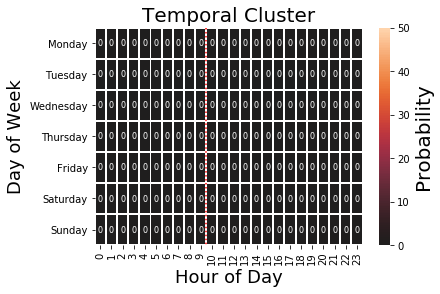

In [323]:
print(cluster_profile)
ax = sns.heatmap(cluster_profile, center=0, vmax=50, linewidths=1, annot=True, annot_kws={"size": 8}, fmt='.0f', cbar_kws={'label': 'Probability'})
ax.set_yticklabels(ordered_days, rotation=0);
ax.figure.axes[-1].yaxis.label.set_size(20)
plt.title("Temporal Cluster", size=20)
plt.xlabel("Hour of Day", size=18)
plt.vlines(x=10, ymax=12, ymin=0, color='red', linestyles=':')
plt.ylabel("Day of Week", size=18)

In [31]:
## lazy work around
if ordered_days[0] == 'Sunday':
    ordered_days.pop(0)
    ordered_days.append('Sunday')
    print("changed")

In [434]:
cluster_profile

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.011, 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.018, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.009, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.009, 0.   , 0.   , 0.   , 0.   , 0.047, 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.045, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.003, 0.007, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.011, 0.014, 0.013, 0.009, 0.016, 0.028, 0.039,
        0.021, 0.015, 0.014, 0.012, 0.009, 0.004],
       [0.003, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.014, 0.022, 0.04 ,
        0.018, 0.01 , 0.011, 0.012, 0.009, 0.007],
       [0.005, 0.004, 0.002, 0.001,

In [37]:
cluster_profile, cluster_purposes = create_cluster_profile(topics[0])


In [640]:
lda_visualization = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)
# pyLDAvis.save_html(lda_visualization, "analysis_results/lda_visualization_5top.html")

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


cafe 0.153
educ 0.122


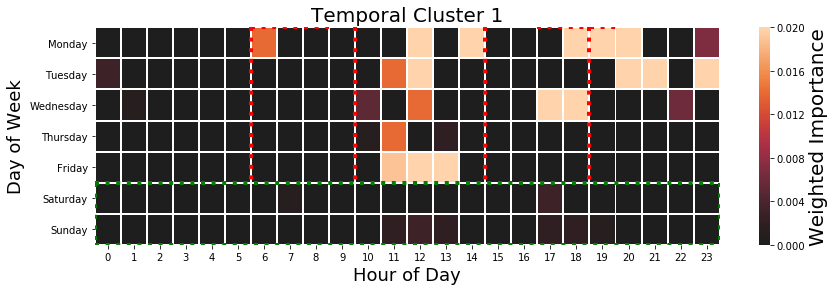

work 0.513


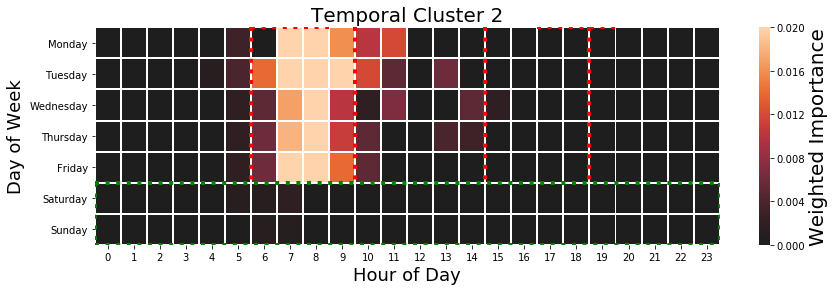

shop 0.35
health 0.048
not_avail 0.001


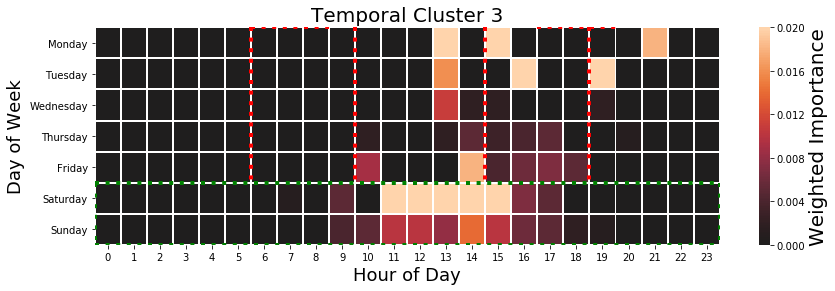

leisur 0.446
pick_up_a_person 0.073


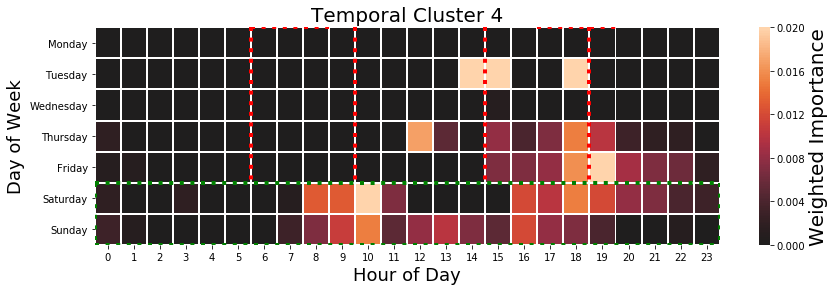

returning_hom 0.6
other 0.022


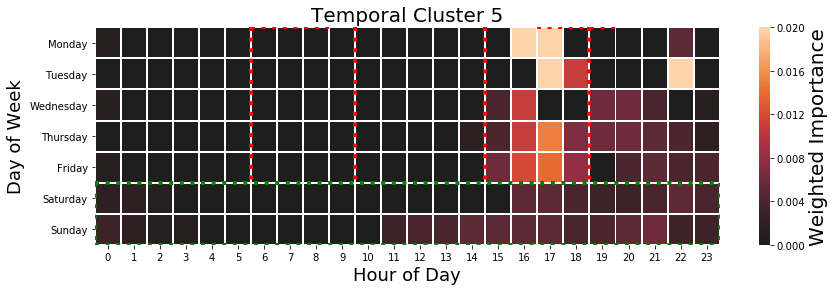

In [750]:
## repeat for all
purposes_clusters = {}
for tp in topics:
    cluster_profile, cluster_purposes = create_cluster_profile(tp)
    purposes_clusters[tp[0]] = cluster_purposes
    print_cluster_content(tp)
    fig, ax = plt.subplots(1, figsize=(14,4))
    sns.heatmap(cluster_profile, center=0, vmax=0.02, linewidths=1, annot_kws={"size": 8}, fmt='.2f', cbar_kws={'label': 'Weighted Importance'})
    ax.set_yticklabels(ordered_days, rotation=0);
    ax.figure.axes[-1].yaxis.label.set_size(20)
    plt.vlines(x=6, ymax=5, ymin=0, color='red', linestyles=':', linewidths=4)
    plt.vlines(x=10, ymax=5, ymin=0, color='red', linestyles=':', linewidths=4)
    plt.vlines(x=15, ymax=5, ymin=0, color='red', linestyles=':', linewidths=4)
    plt.vlines(x=19, ymax=5, ymin=0, color='red', linestyles=':', linewidths=4)
    plt.hlines(y=0, xmin=6, xmax=9, color='red', linestyles=':', linewidths=4)
    plt.hlines(y=0, xmin=17, xmax=20, color='red', linestyles=':', linewidths=4)
    plt.hlines(y=5, xmin=0, xmax=25, color='green', linestyles=':', linewidths=4)
    plt.hlines(y=7, xmin=0, xmax=25, color='green', linestyles=':', linewidths=4)
    plt.vlines(x=0, ymax=7, ymin=5, color='green', linestyles=':', linewidths=4)
    plt.vlines(x=24, ymax=7, ymin=5, color='green', linestyles=':', linewidths=4)

    
#     ax.figure.axes[-1].set_yticklabels([''])
    plt.title("Temporal Cluster {}".format(tp[0]+1), size=20)
    plt.xlabel("Hour of Day", size=18)
    plt.ylabel("Day of Week", size=18)
#     plt.savefig("figures/temporal_cluster{0}.png".format(tp[0]+1), bbox_inches='tight')
    plt.show()

In [722]:
def link_topic_to_lda(row):
    row['lda_word']

In [723]:
topics[0][1]

'0.177*"tuesday_20" + 0.153*"cafe" + 0.125*"tuesday_21" + 0.122*"educ" + 0.044*"monday_18" + 0.036*"wednesday_17" + 0.028*"tuesday_12" + 0.027*"friday_12" + 0.027*"monday_19" + 0.026*"tuesday_23" + 0.024*"monday_20" + 0.024*"wednesday_18" + 0.022*"monday_12" + 0.022*"monday_14" + 0.021*"friday_13" + 0.019*"friday_11" + 0.014*"tuesday_11" + 0.014*"wednesday_12" + 0.014*"monday_6" + 0.014*"thursday_11" + 0.007*"monday_23" + 0.006*"wednesday_22" + 0.005*"wednesday_10" + 0.003*"sunday_12" + 0.003*"saturday_17" + 0.003*"tuesday_0" + 0.002*"sunday_13" + 0.002*"sunday_17" + 0.002*"sunday_11" + 0.002*"thursday_13" + 0.002*"sunday_18" + 0.001*"sunday_19" + 0.001*"thursday_10" + 0.001*"saturday_7" + 0.001*"wednesday_1" + 0.000*"thursday_3" + 0.000*"sunday_16" + 0.000*"monday_7" + 0.000*"monday_2" + 0.000*"monday_1" + 0.000*"monday_8" + 0.000*"monday_17" + 0.000*"sunday_0" + 0.000*"tuesday_13" + 0.000*"returning_hom" + 0.000*"monday_11" + 0.000*"saturday_19" + 0.000*"sunday_14" + 0.000*"tuesday_7

In [724]:
def topic_to_lda(row):
    """
        function for determining which temporal cluster each row falls into
    """
    if not row['lda_word']:
        return 0
    values = []
    for tpc in topics:
        tp_val = 0
        ind_tp = get_individual_topics(tpc)
        for it in ind_tp:
            val, tp = strip_unneeded_chars(it)
            dt, pur = row['lda_word'].split(',')
            if dt.lower() == tp:
                tp_val+= val
            elif pur.strip(' ').startswith(pur):
                tp_val+= val
        values.append(tp_val)
    # return the cluster with highest value
    return np.argmax(values) + 1


In [730]:
gdf.columns

Index(['id_trip', 'mode', 'purpose', 'starttime', 'endtime', 'seconds',
       'distance_m', 'direction', 'magnitude', 'carddir', 'start_down',
       'end_downto', 'starthour', 'endhour', 'weekday', 'startrush', 'endrush',
       'thrurush', 'precip', 'temperatur', 'start_wgs', 'end_wgs', 'start_can',
       'end_can', 'geometry', 'hour', 'lda_word', 'temporal_cluster'],
      dtype='object')

In [739]:
# gdf.drop(['temporal_cluster'], axis=1, inplace=True)

In [740]:
%%time
gdf['temporal_cluster'] = gdf.apply(topic_to_lda, axis=1)

CPU times: user 13min 55s, sys: 5.81 s, total: 14min 1s
Wall time: 14min 42s


In [762]:
temp_cluster_vals = gdf.temporal_c.value_counts().to_dict()
temp_cluster_vals

{0: 111067, 2: 17992, 4: 17640, 5: 15992, 3: 11431, 1: 11163}

In [742]:
temp_cluster_vals

{0: 111067, 2: 17992, 4: 17640, 5: 15992, 3: 11431, 1: 11163}

In [746]:
gdf

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,precip,temperatur,start_wgs,end_wgs,start_can,end_can,geometry,hour,lda_word,temporal_cluster
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,1.900323e-02,WNW,...,0.000004,21.655905,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...,0,None,0
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,3.135046e-01,W,...,0.000000,20.182104,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...,2,None,0
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,2.721037e-01,SE,...,0.000000,18.353766,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...,5,None,0
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,3.040857e-01,E,...,0.000000,18.353766,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...,6,"Monday_6, pick_up_a_person",1
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,2.554853e-01,E,...,0.000000,18.353766,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...,6,None,0
5,421155,None,None,2017-09-18 06:42:13-04:00,2017-09-18 06:45:16-04:00,183,530.737088,66.286377,3.251784e-01,ENE,...,0.000000,18.353766,POINT (-73.45155700000004 45.74749099999982),POINT (-73.44648500000002 45.7488929999998),POINT (7632650.98172996 1273797.68928672),POINT (7632989.362858895 1274063.356276445),"LINESTRING (7632650.98172996 1273797.68928672,...",6,None,0
6,29064,None,None,2017-09-18 06:47:52-04:00,2017-09-18 06:49:34-04:00,102,90.537212,225.258580,4.075197e-01,SW,...,0.000000,18.353766,POINT (-73.56574500000005 45.51009499999979),POINT (-73.56641300000003 45.51001499999981),POINT (7631610.128197737 1245567.675562556),POINT (7631561.883890274 1245543.987149366),(LINESTRING (7631626.545535451 1245629.5916483...,6,None,0
7,203781,None,None,2017-09-18 06:53:49-04:00,2017-09-18 07:16:31-04:00,1362,8605.960727,123.191659,3.256624e-01,ESE,...,0.000000,17.440628,POINT (-73.56183100000007 45.51437399999979),POINT (-73.56330200000005 45.51500699999978),POINT (7631770.802031942 1246118.630389794),POINT (7631638.671248137 1246153.989722969),(LINESTRING (7623626.441304226 1247943.3070560...,6,None,0
8,273549,None,None,2017-09-18 06:54:50-04:00,2017-09-18 07:08:43-04:00,833,11432.721024,13.240337,2.935558e-01,NNE,...,0.000000,17.440628,POINT (-73.44588800000005 45.7523189999998),POINT (-73.42086200000004 45.82959999999981),POINT (7632924.248795619 1274446.797314812),POINT (7632326.330171747 1283354.4540747),LINESTRING (7632924.248795619 1274446.79731481...,6,None,0
9,314196,None,None,2017-09-18 06:57:01-04:00,2017-09-18 07:23:51-04:00,1610,7770.617747,34.373388,2.572517e-01,NE,...,0.000000,17.440628,POINT (-73.66851600000004 45.44199299999978),POINT (-73.62876200000002 45.47846499999979),POINT (7625960.44123376 1235889.569612722),POINT (7627825.844729592 1240729.001491461),LINESTRING (7625960.44123376 1235889.569612722...,6,None,0


In [747]:
gdf['starttime'] = gdf['starttime'].astype(str)
gdf['endtime'] = gdf['endtime'].astype(str)
gdf['start_wgs'] = gdf['start_wgs'].astype(str)
gdf['start_can'] = gdf['start_can'].astype(str)
gdf['end_wgs'] = gdf['end_wgs'].astype(str)
gdf['end_can'] = gdf['end_can'].astype(str)

In [748]:
gdf[["id_trip","mode","purpose","starttime","endtime","seconds","distance_m","direction","magnitude","carddir","start_down","end_downto","starthour","endhour","weekday","startrush","endrush", "thrurush","lda_word", "temporal_cluster", 'precip', 'temperatur',"start_wgs","end_wgs","start_can","end_can", "geometry"]]

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,thrurush,lda_word,temporal_cluster,precip,temperatur,start_wgs,end_wgs,start_can,end_can,geometry
0,1547,None,None,2017-09-18 00:16:58-04:00,2017-09-18 00:26:26-04:00,568,1530.222174,303.572980,1.900323e-02,WNW,...,0,None,0,0.000004,21.655905,POINT (-73.65116600000005 45.54450099999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624015.797731058 1247372.359122399),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624015.797731058 1247372.35912239...
1,308312,None,None,2017-09-18 02:17:46-04:00,2017-09-18 02:58:49-04:00,2463,324.869460,274.079216,3.135046e-01,W,...,0,None,0,0.000000,20.182104,POINT (-73.65098700000003 45.54449599999979),POINT (-73.65475300000004 45.5455209999998),POINT (7624029.565886399 1247375.825611254),POINT (7623710.593941391 1247402.423920968),LINESTRING (7624029.565886399 1247375.82561125...
2,384772,None,None,2017-09-18 05:30:24-04:00,2017-09-18 06:17:28-04:00,2824,32009.701647,130.691098,2.721037e-01,SE,...,0,None,0,0.000000,18.353766,POINT (-73.79999600000002 45.63632099999982),POINT (-73.62417100000005 45.53094099999978),POINT (7609795.133960674 1253993.059622761),POINT (7626500.696944128 1246510.141318924),(LINESTRING (7607307.107749196 1253237.7069476...
3,150744,car,pick_up_a_person,2017-09-18 06:02:50-04:00,2017-09-18 06:17:12-04:00,862,9935.922336,85.310969,3.040857e-01,E,...,1,"Monday_6, pick_up_a_person",1,0.000000,18.353766,POINT (-73.64638500000002 45.54628999999979),POINT (-73.54531800000002 45.55066099999977),POINT (7624322.265039737 1247672.970059534),POINT (7631863.767736516 1250414.940902869),LINESTRING (7624322.265039737 1247672.97005953...
4,199011,None,None,2017-09-18 06:18:40-04:00,2017-09-18 06:27:44-04:00,544,563.806088,96.630699,2.554853e-01,E,...,1,None,0,0.000000,18.353766,POINT (-73.74527300000005 45.55845599999979),POINT (-73.72059400000005 45.55950099999978),POINT (7616417.181546402 1246781.286979011),POINT (7618260.407733496 1247444.31208628),(LINESTRING (7616402.393582945 1246769.1996916...
5,421155,None,None,2017-09-18 06:42:13-04:00,2017-09-18 06:45:16-04:00,183,530.737088,66.286377,3.251784e-01,ENE,...,1,None,0,0.000000,18.353766,POINT (-73.45155700000004 45.74749099999982),POINT (-73.44648500000002 45.7488929999998),POINT (7632650.98172996 1273797.68928672),POINT (7632989.362858895 1274063.356276445),"LINESTRING (7632650.98172996 1273797.68928672,..."
6,29064,None,None,2017-09-18 06:47:52-04:00,2017-09-18 06:49:34-04:00,102,90.537212,225.258580,4.075197e-01,SW,...,1,None,0,0.000000,18.353766,POINT (-73.56574500000005 45.51009499999979),POINT (-73.56641300000003 45.51001499999981),POINT (7631610.128197737 1245567.675562556),POINT (7631561.883890274 1245543.987149366),(LINESTRING (7631626.545535451 1245629.5916483...
7,203781,None,None,2017-09-18 06:53:49-04:00,2017-09-18 07:16:31-04:00,1362,8605.960727,123.191659,3.256624e-01,ESE,...,1,None,0,0.000000,17.440628,POINT (-73.56183100000007 45.51437399999979),POINT (-73.56330200000005 45.51500699999978),POINT (7631770.802031942 1246118.630389794),POINT (7631638.671248137 1246153.989722969),(LINESTRING (7623626.441304226 1247943.3070560...
8,273549,None,None,2017-09-18 06:54:50-04:00,2017-09-18 07:08:43-04:00,833,11432.721024,13.240337,2.935558e-01,NNE,...,1,None,0,0.000000,17.440628,POINT (-73.44588800000005 45.7523189999998),POINT (-73.42086200000004 45.82959999999981),POINT (7632924.248795619 1274446.797314812),POINT (7632326.330171747 1283354.4540747),LINESTRING (7632924.248795619 1274446.79731481...
9,314196,None,None,2017-09-18 06:57:01-04:00,2017-09-18 07:23:51-04:00,1610,7770.617747,34.373388,2.572517e-01,NE,...,1,None,0,0.000000,17.440628,POINT (-73.66851600000004 45.44199299999978),POINT (-73.62876200000002 45.47846499999979),POINT (7625960.44123376 1235889.569612722),POINT (7627825.844729592 1240729.001491461),LINESTRING (7625960.44123376 1235889.569612722...


In [749]:
# gdf[["id_trip","mode","purpose","starttime","endtime","seconds","distance_m","direction","magnitude","carddir","start_down","end_downto","starthour","endhour","weekday","startrush","endrush", "thrurush","lda_word", "temporal_cluster", 'precip', 'temperatur',"start_wgs","end_wgs","start_can","end_can", "geometry"]].to_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8')

In [763]:
temp_cluster_vals

{0: 111067, 2: 17992, 4: 17640, 5: 15992, 3: 11431, 1: 11163}

In [764]:
list(temp_cluster_vals.keys())

[0, 2, 4, 5, 3, 1]

[111067, 17992, 17640, 15992, 11431, 11163]

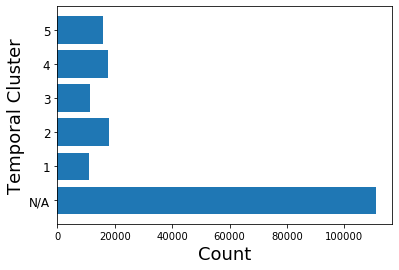

In [775]:
fig, ax = plt.subplots(1)
ax.barh(y=list(temp_cluster_vals.keys()), width=temp_cluster_vals.values())
ax.set_yticklabels(labels=['','N/A','1','2','3','4','5','7'], size=12)
ax.set_xlabel("Count", size=18)
ax.set_ylabel("Temporal Cluster", size=18)
# plt.savefig("figures/lda_temp_cluster_hist_na.png", bbox_inches='tight')

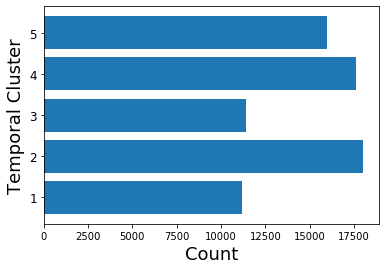

In [774]:
fig, ax = plt.subplots(1)
ax.barh(y=list(temp_cluster_vals.keys())[1:] ,width=list(temp_cluster_vals.values())[1:])
ax.set_yticklabels(labels=['NA','1','2','3','4','5'], size=12)
ax.set_xlabel("Count", size=18)
ax.set_ylabel("Temporal Cluster", size=18)
# plt.savefig("figures/lda_temp_cluster_hist.png", bbox_inches='tight')

In [776]:
purposes_clusters

{0: [['cafe', 0.153], ['educ', 0.122]],
 1: [['work', 0.513]],
 2: [['shop', 0.35], ['health', 0.048], ['not_avail', 0.001]],
 3: [['leisur', 0.446], ['pick_up_a_person', 0.073]],
 4: [['returning_hom', 0.6], ['other', 0.022]]}

#### Interpretting LDA Results:
Each generated topic is separated by a comma. Within each topic are the three most probable words to appear in that topic.